In [8]:
import yfinance as yf
import numpy as np
import jax
import jax.numpy as jnp
from bures_wasserstein import BuresWasserstein
import matplotlib.pyplot as plt

data = yf.download("AAPL", interval="1m", period="7d")
returns = data["Adj Close"].pct_change().dropna().values

wt_len = 2
W_t = np.array(
    [returns[i : i + wt_len] for i in range(0, len(returns) - wt_len + 1, wt_len)]
)

window_size = 30
cov_matrices = []
for i in range(1, len(W_t) - window_size + 1, window_size):
    cov_matrices.append(np.cov(W_t[i : i + window_size], rowvar=False))

cov_matrices = np.array(cov_matrices) / returns.var()

BuresWasserstein.frechet_mean(
    jnp.array(cov_matrices), jax.random.PRNGKey(np.random.randint(0, 2**32))
)

[*********************100%***********************]  1 of 1 completed


Array([[ 0.9297161 , -0.00395729],
       [-0.00395729,  0.8833961 ]], dtype=float32)

In [40]:
import numpy as np

times = np.array([22.5, 23.5, 0.5, 1.0, 2.5, 20.5, 21])

print("y", times / 24 * 4)
print("angles", 90 - times / 24 * 360)

angles = (90 - times / 24 * 360) / 180 * np.pi

print(times.mean(), ", scale=", times.mean() / 24 * 4)

print(np.c_[np.cos(angles), np.sin(angles)].mean(axis=0))

y [3.75       3.91666667 0.08333333 0.16666667 0.41666667 3.41666667
 3.5       ]
angles [-247.5 -262.5   82.5   75.    52.5 -217.5 -225. ]
13.071428571428571 , scale= 2.1785714285714284
[-0.14508044  0.85455952]


In [43]:
times_centered = np.array([22.5 - 24, 23.5 - 24, 0.5, 1.0, 2.5, 20.5 - 24, 21 - 24])
fm = times_centered.mean() + 24
print(fm, ", angle=", 90 - fm / 24 * 360)

23.357142857142858 , angle= -260.35714285714283


In [23]:
((90 - angles * 180 / np.pi) / 360 * 24).mean()

13.60952380952381

<Figure size 1000x600 with 0 Axes>

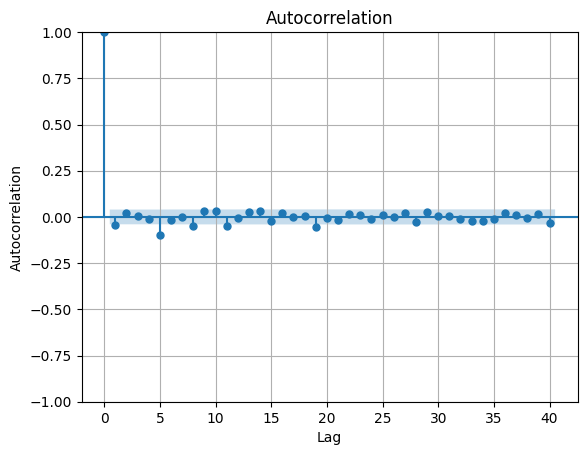

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(returns, lags=40)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

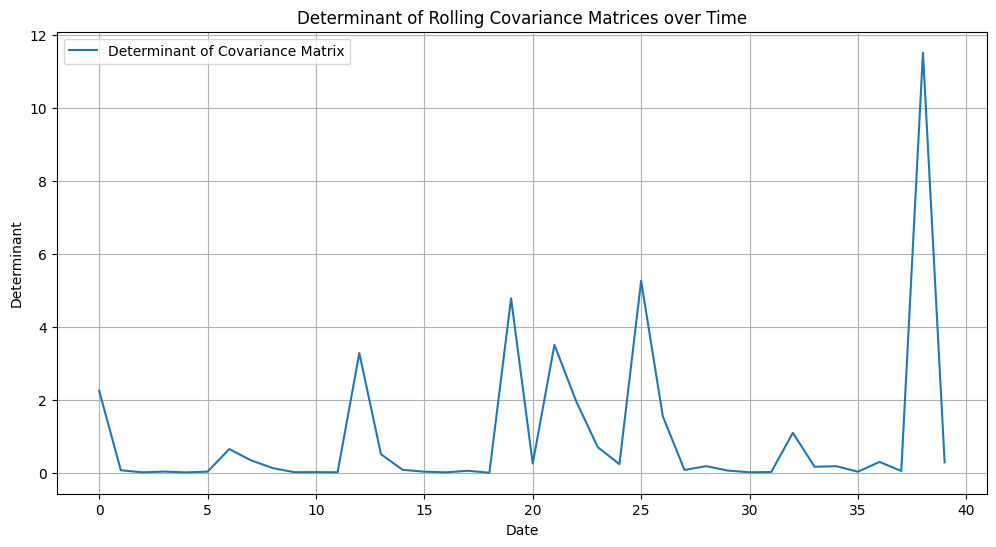

In [10]:
determinants = [np.linalg.det(matrix) for matrix in cov_matrices]

plt.figure(figsize=(12, 6))
plt.plot(
    determinants,
    label="Determinant of Covariance Matrix",
)
plt.title("Determinant of Rolling Covariance Matrices over Time")
plt.xlabel("Date")
plt.ylabel("Determinant")
plt.legend()
plt.grid(True)
plt.show()

Array(0.063, dtype=float32)

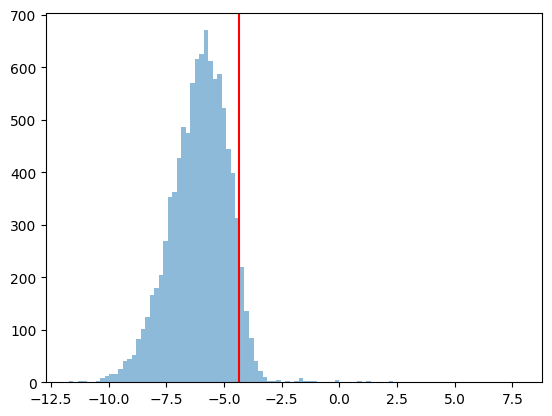

In [11]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from manifold import mirror_vecs


def mixture(key, x0, x1, p):
    num_dims = len(x0.shape) - 1
    shape = (x0.shape[0], *[1 for _ in range(num_dims)])
    z = jax.random.choice(
        key, jnp.array([0.0, 1.0]), shape=shape, p=jnp.array([p, 1 - p])
    )
    return z * x0 + (1.0 - z) * x1


num_bootstrap = 10_000


def proc_inner(M, x, mu_0, key):
    fm_key, key = jax.random.split(key, 2)
    x_mirrored = mirror_vecs(M, mu_0, x)

    mu_hat = M.frechet_mean(x, fm_key)
    t = M.dist(mu_hat, mu_0) ** 2

    def fun(it_key):
        z_key, fm_key = jax.random.split(it_key)
        x_b = mixture(z_key, x, x_mirrored, 1 / 2)
        mu_hat_b = M.frechet_mean(x_b, fm_key)
        return M.dist(mu_hat_b, mu_0) ** 2

    t_b = jax.vmap(fun)(jax.random.split(key, num_bootstrap))
    return t, t_b


t, t_b = proc_inner(
    BuresWasserstein,
    jnp.array(cov_matrices),
    jnp.eye(2),
    jax.random.PRNGKey(np.random.randint(0, 2**32)),
)

plt.axvline(np.log(t), color="red", label="T")
plt.hist(np.log(t_b), bins=100, alpha=0.5, label="T_b")
(t_b >= t).mean()